# Federated Learning for Sequential (Text) data

In [1]:
import os
import torch
import nltk
import torch
import flwr as fl
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch import nn
from torch import optim
from nltk.lm import Vocabulary
from nltk.corpus import reuters
from typing import Dict
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder
from flwr.common import NDArrays, Scalar
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score



DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE} using PyTorch {torch.__version__}")



/Users/maxkleinegger/Desktop/test/speml.nosync/federated-text-classification/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-31 15:06:15,411	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Training on cpu using PyTorch 2.4.0


## Parameters

In [26]:
# Dataset hyperparameters
MAX_LEN = 60

# Model hyperparameters
EMBED_SIZE = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 2
DROPOUT = 0.5

# Training hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.01
NUM_EPOCHS = 100
NUM_CLIENTS = 2

# General hyperparameters
RANDOM_STATE = 42
VERBOSE = True
np.random.seed(RANDOM_STATE)

## Load data

In [3]:
class ReutersDataset(Dataset):
    def __init__(self, texts: list[list[int]], labels: list[int], maxlen: int):
        self.texts = [text[:maxlen] for text in texts]
        self.labels = labels
        self.maxlen = maxlen

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx: int):
        text = torch.tensor(self.texts[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return text, label

In [4]:
def _collate_fn(batch: list[tuple[list[int], list[int]]], vocab: Vocabulary):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    labels = torch.tensor(labels, dtype=torch.long)
    return texts_padded, labels


def _remove_stopwords(text: list[str]) -> pd.Series:
    stop = set(nltk.corpus.stopwords.words("english"))
    return (
        pd.Series(text)
        .str.lower()
        .replace(r"[^\w\s]", "", regex=True)
        .apply(nltk.word_tokenize)
        .apply(
            lambda sentence: " ".join([word for word in sentence if word not in stop])
        )
    )


def _process_labels(labels: list[list[str]]) -> pd.Series:
    return pd.Series(labels).apply(lambda x: x[0] if x else "unknown")


def load_dataset(maxlen: int):
    nltk.download("reuters")
    nltk.download("stopwords")
    nltk.download("punkt")

    # Load documents and their categories
    documents = reuters.fileids()
    categories = [reuters.categories(fileid) for fileid in documents]

    # Load document content
    data = [reuters.raw(fileid) for fileid in documents]

    text = _remove_stopwords(data)
    tokens = [nltk.word_tokenize(sentence) for sentence in text]

    # Flatten the list of tokens for vocabulary creation
    flat_tokens = [token for sentence in tokens for token in sentence]
    vocab = Vocabulary(flat_tokens)

    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(_process_labels(categories))

    # Add a padding token to the vocabulary
    vocab.update(["<pad>"])
    encoded_texts = [[vocab[token] for token in sentence] for sentence in tokens]

    # Apply maxlen to encoded texts
    encoded_texts = [text[:maxlen] for text in encoded_texts]

    encoded_df = pd.DataFrame(
        {
            "text": encoded_texts,
            "category": labels,
        }
    )

    return encoded_df, vocab, label_encoder


def create_dataloader(text: pd.Series, labels: pd.Series, vocab: Vocabulary, maxlen: int,shuffle: bool = True) -> DataLoader:
    dataset = ReutersDataset(text.tolist(), labels.tolist(), maxlen)
    return DataLoader(
        dataset,
        batch_size=32,
        shuffle=shuffle,
        collate_fn=lambda x: _collate_fn(x, vocab),
    )


In [5]:
# Load the dataset
df, vocab, label_encoder = load_dataset(MAX_LEN)

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/maxkleinegger/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxkleinegger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxkleinegger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# Split the data
from sklearn.model_selection import train_test_split


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["category"], test_size=0.2, random_state=RANDOM_STATE
)

In [7]:
train_loader = create_dataloader(train_texts, train_labels, vocab, MAX_LEN)
test_loader = create_dataloader(test_texts, test_labels, vocab, MAX_LEN, shuffle=False)

## State of the art baseline

### Implementation

In [8]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, vocab_size: int, output_size: int, padding_idx: int, embed_size=128, hidden_size=256, num_layers=2, dropout=0.5):
        super(BidirectionalLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.rnn = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.rnn(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        out = self.dropout(hidden)
        out = self.fc(out)
        return out


In [9]:
def train_model(model: nn.Module, train_loader: DataLoader, num_epochs: int, optimizer: optim.Optimizer, device: torch.device = DEVICE, verbose=False):
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0
        correct = 0
        total = 0

        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

In [10]:
def evaluate_model(model: nn.Module, test_loader: DataLoader, device = DEVICE, verbose=False):
    criterion = nn.CrossEntropyLoss()
    model.eval()

    total, correct = 0, 0
    total_loss = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    total_loss /= len(test_loader)
    accuracy = correct / total

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    if verbose:
        print(f"Test Loss: {total_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    return total_loss, accuracy, precision, recall, f1

### Training

In [19]:
def run_centralised(model, train_loader: DataLoader, test_loader: DataLoader, epochs: int, lr: float, momentum: float = 0.9, device: torch.device = DEVICE, verbose=False):
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    train_model(model, train_loader, epochs, optim, device)
    loss, accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)

    if verbose:
        print(f"Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    return accuracy, loss, precision, recall, f1


In [12]:
model = BidirectionalLSTM(
    vocab_size=len(vocab),
    output_size= len(label_encoder.classes_),
    padding_idx=vocab["<pad>"],
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

In [13]:
acc_baseline, _, _, _, _ = run_centralised(model, train_loader, test_loader, epochs=NUM_EPOCHS, lr=LEARNING_RATE, verbose=VERBOSE)

100%|██████████| 1/1 [00:36<00:00, 36.71s/it]


Accuracy: 0.5051, Loss: 2.0296
Precision: 0.7840, Recall: 0.5051, F1 Score: 0.4080


### Additional Training

In [20]:
file_path = "results/results_baseline.csv"
os.makedirs("results", exist_ok=True)

In [21]:
model = BidirectionalLSTM(
    vocab_size=len(vocab),
    output_size= len(label_encoder.classes_),
    padding_idx=vocab["<pad>"],
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

epochs_count = 0
for epochs in [1, 1, 3, 5, 15, 25, 50]:
    epochs_count += epochs
    acc_no_fed, loss_no_fed, precision, recall, f1 = run_centralised(model, train_loader, test_loader, epochs=epochs, lr=LEARNING_RATE, verbose=False)
    with open(file_path, "a") as file:
        file.write(f"{epochs_count},{acc_no_fed},{loss_no_fed},{precision},{recall},{f1}\n")


100%|██████████| 25/25 [17:01<00:00, 40.85s/it]
/Users/maxkleinegger/Desktop/test/speml.nosync/federated-text-classification/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 50/50 [32:05<00:00, 38.50s/it]
/Users/maxkleinegger/Desktop/test/speml.nosync/federated-text-classification/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 66min

## LSTM to be federated

### Implementation

In [27]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        output_size: int,
        padding_idx: int,
        embed_size=128,
        hidden_size=256,
        num_layers=2,
        dropout=0.5,
    ):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.rnn = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.rnn(embedded)
        hidden = hidden[-1]
        out = self.dropout(hidden)
        out = self.fc(out)
        return out

### Training

In [28]:
model = LSTM(
    vocab_size=len(vocab),
    output_size= len(label_encoder.classes_),
    padding_idx=vocab["<pad>"],
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

In [ ]:
acc_baseline, _, _, _, _ = run_centralised(model, train_loader, test_loader, epochs=NUM_EPOCHS, lr=LEARNING_RATE, verbose=VERBOSE)

### Additional Training

In [ ]:
file_path = "results/results_baseline.csv"
os.makedirs("results", exist_ok=True)

In [ ]:
model = LSTM(
    vocab_size=len(vocab),
    output_size= len(label_encoder.classes_),
    padding_idx=vocab["<pad>"],
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

epochs_count = 0
for epochs in [1, 1, 3, 5, 15, 25, 50]:
    epochs_count += epochs
    acc_no_fed, loss_no_fed, precision, recall, f1 = run_centralised(model, train_loader, test_loader, epochs=epochs, lr=LEARNING_RATE, verbose=False)
    with open(file_path, "a") as file:
        file.write(f"{epochs_count},{acc_no_fed},{loss_no_fed},{precision},{recall},{f1}\n")


### Federated LSTM

#### Partition data

In [30]:
def partition_dataset(train_loader, test_loader, vocab: Vocabulary, num_partitions: int, batch_size: int, val_ratio: float = 0.1,):
    # Extract dataset from DataLoader
    train_dataset = train_loader.dataset
    test_dataset = test_loader.dataset

    # Calculate partition lengths
    num_images = len(train_dataset)
    partition_len = [num_images // num_partitions] * num_partitions
    partition_len[-1] += (
        num_images % num_partitions
    )  # Add remainder to the last partition

    trainsets = random_split(
        train_dataset, partition_len, torch.Generator().manual_seed(2023)
    )

    # Create DataLoaders with train+val support
    trainloaders = []
    valloaders = []
    for trainset in trainsets:
        num_total = len(trainset)
        num_val = int(val_ratio * num_total)
        num_train = num_total - num_val

        train_subset, val_subset = random_split(trainset, [num_train, num_val], torch.Generator().manual_seed(2023))

        trainloaders.append(DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=lambda x: _collate_fn(x, vocab)))
        valloaders.append(DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=lambda x: _collate_fn(x, vocab)))

    # Create DataLoader for the test set
    testloader = DataLoader(test_dataset, batch_size=128, collate_fn=lambda x: _collate_fn(x, vocab))

    return trainloaders, valloaders, testloader

In [31]:
trainloaders, valloaders, testloader = partition_dataset(train_loader, test_loader, vocab, NUM_CLIENTS, BATCH_SIZE)

##### Visualization

number of articles: 3884


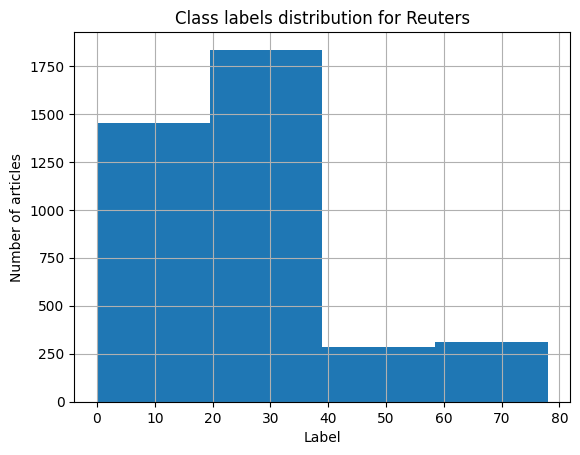

In [32]:
import matplotlib.pyplot as plt

# first partition
train_partition = trainloaders[1].dataset

# count data points
partition_indices = train_partition.indices
print(f"number of articles: {len(partition_indices)}")

# visualise histogram
plt.hist(
    [train_partition.dataset[idx][1].item() for idx in partition_indices], bins=4
)  # 46 classes in Reuters dataset
plt.grid()
plt.xlabel("Label")
plt.ylabel("Number of articles")
plt.title("Class labels distribution for Reuters")
plt.show()

### Client

In [33]:
class ReutersClient(fl.client.NumPyClient):
    def __init__(self, vocab_size, output_size, padding_idx, embed_size, hidden_size, num_layers, dropout, device, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.model = LSTM(
            vocab_size=vocab_size,
            output_size= output_size,
            padding_idx=padding_idx,
            embed_size=embed_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout
        ).to(device)
        self.device = device
    def set_parameters(self, parameters):
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)
        train_model(model=self.model, train_loader=self.trainloader, num_epochs=1, optimizer=optim, device=self.device, verbose=False,)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        self.set_parameters(parameters)
        loss, accuracy, precision, recall, f1 = evaluate_model(self.model, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [34]:
def get_evaluate_fn(vocab_size, output_size, padding_idx, embed_size, hidden_size, num_layers, dropout, device, testloader):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = LSTM(
            vocab_size=vocab_size,
            output_size= output_size,
            padding_idx=padding_idx,
            embed_size=embed_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout
        ).to(device)
        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test
        loss, accuracy, precision, recall, f1 = evaluate_model(
            model, testloader
        )  # <-------------------------- calls the `test` function, just what we did in the centralised setting
        return loss, {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

    return evaluate_fn

In [35]:
def generate_client_fn(vocab_size, output_size, padding_idx, embed_size, hidden_size, num_layers, dropout, device, trainloaders, valloaders):
    def client_fn(cid: str):
        return ReutersClient(vocab_size, output_size, padding_idx, embed_size, hidden_size, num_layers, dropout, device, trainloader=trainloaders[int(cid)], valloader=valloaders[int(cid)]).to_client()

    return client_fn

### Server

In [36]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1, 
    fraction_evaluate=1,  
    min_available_clients=NUM_CLIENTS, 
    evaluate_fn=get_evaluate_fn(len(vocab), len(label_encoder.classes_), vocab["<pad>"], EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT, DEVICE, testloader)
)

In [37]:
client_fn_callback = generate_client_fn(len(vocab), len(label_encoder.classes_), vocab["<pad>"], EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT, DEVICE, trainloaders, valloaders)


### Training

In [39]:
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_EPOCHS),
    strategy=strategy,
)

INFO :      Starting Flower simulation, config: num_rounds=100, no round_timeout
2024-07-31 16:22:19,523	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7326475879.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 10.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 10 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(ClientAppActor pid=38538) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You c

In [58]:
# Initialize an empty list to store the data
rows = []

# Assuming all lists are of the same length and in the same order
for i in range(len(history.metrics_centralized['accuracy'])):
    loss = history.losses_centralized[i][1]
    epoch = history.metrics_centralized['accuracy'][i][0]
    accuracy = history.metrics_centralized['accuracy'][i][1]
    precision = history.metrics_centralized['precision'][i][1]
    recall = history.metrics_centralized['recall'][i][1]
    f1 = history.metrics_centralized['f1'][i][1]
    
    # Append a dictionary for each epoch
    rows.append({
        'epoch_nr': epoch,
        'accuracy': accuracy,
        "loss": loss,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# Convert the list of dictionaries to a pandas DataFrame
df_metrics = pd.DataFrame(rows)
df_metrics.to_csv("results/results_federated_2_clients.csv", index=False)

history.metrics_centralized = {'accuracy': [(0, 0.030583873957367932), (1, 0.3614457831325301), (2, 0.3614457831325301), (3, 0.3614457831325301), (4, 0.3873957367933272), (5, 0.3901760889712697), (6, 0.5171455050973123), (7, 0.24003707136237257), (8, 0.4054680259499537), (9, 0.37025023169601484), (10, 0.4545875810936052), (11, 0.5032437442075997), (12, 0.5329008341056534), (13, 0.5347544022242817), (14, 0.5287303058387396), (15, 0.5389249304911955), (16, 0.5426320667284523), (17, 0.42910101946246526), (18, 0.5370713623725671), (19, 0.5379981464318814), (20, 0.540778498609824), (21, 0.5430954587581094), (22, 0.5319740500463392), (23, 0.5495829471733086), (24, 0.5027803521779426), (25, 0.2789620018535681), (26, 0.5329008341056534), (27, 0.21733086190917517), (28, 0.3614457831325301), (29, 0.36190917516218724), (30, 0.36190917516218724), (31, 0.5069508804448564), (32, 0.4865616311399444), (33, 0.3943466172381835), (34, 0.5458758109360519), (35, 0.5472659870250232), (36, 0.5741427247451344

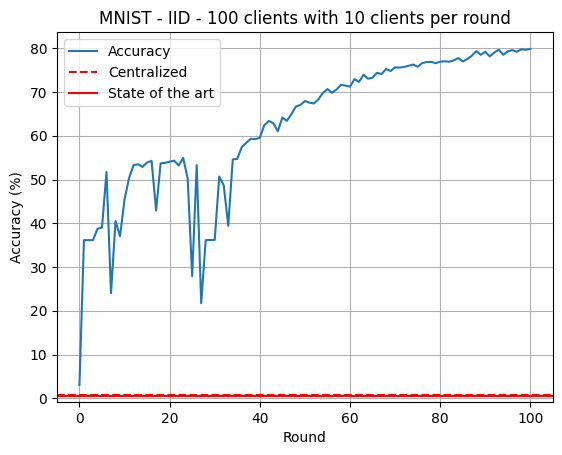

In [65]:
# Assuming `history.metrics_centralized` contains the data as described
print(f"{history.metrics_centralized = }")

rounds = df['epoch_nr']
acc = df['accuracy'] * 100.0  # Convert to percentage

# Plot the accuracy values
plt.plot(rounds, acc, label='Accuracy')
plt.axhline(y=acc_no_fed, color='r', linestyle='--', label='Centralized')
plt.axhline(y=acc_baseline, color='r', linestyle='-', label='State of the art')
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 100 clients with 10 clients per round")
plt.legend()

plt.show()